In [1]:
import sys
sys.path.append('/Users/mahsazarei/Grantlab Brugada Dropbox/TerraMera/Gitlab/Mahsa/AA_APLID/Amino_Acid_manuscript/helper_functions')
from load_data import *
from utils import *
from models import *
root_dir = "/Users/mahsazarei/Grantlab Brugada Dropbox/TerraMera/Gitlab/Mahsa/AA_APLID/Amino_Acid_manuscript/Data"

# 1. Read Amino Acids (AA) data

In [2]:
df_aa = pd.read_csv(os.path.join(root_dir, 'AA_Data/AA_Data.csv'))
w = [c for c in df_aa.columns if c[0] in np.array(range(10), dtype=str)]

mask_aa = [col.startswith('a') for col in df_aa['vial #']]
names_aa = np.array([col for col in df_aa['vial #'] if col.startswith('a')])
wnums = np.array([float(idx) for idx in w])
specs_aa = df_aa.loc[mask_aa, w].values
w_cm = wavelength_to_wavenumber(wnums, 784.815734863281)
y_names = ['Alanine', 'Asparagine', 'Aspartic Acid', 'Glutamic Acid',
       'Histidine', 'Glucosamine']
y_aa = df_aa.loc[mask_aa, y_names].values

mask_pure = [not col.startswith('a') for col in df_aa['vial #']]
names_pure = np.array([col for col in df_aa['vial #'] if not col.startswith('a')])
specs_pure = df_aa.loc[mask_pure, w].values
print(y_aa.shape, specs_aa.shape, names_aa.shape, specs_pure.shape, names_pure.shape)

(4318, 6) (4318, 1024) (4318,) (60, 1024) (60,)


# 2. Read Amino Acids with Fluorescence (AAF) data

In [3]:
specs_f, w_cm, w_nm, names_f = data_loader_by_path(os.path.join(root_dir, 'AAF_Data'), skiprows=45)
specs_f = specs_f.T

df_gt_f, y_f, _, namess= y_loader_by_path(os.path.join(root_dir, 'AA_GroundTruth/AAF_proportions.xlsx'))
y_expanded = [y_f[df_gt_f.index==name] for name in names_f]
y_f = np.vstack(y_expanded)
print(specs_f.shape, names_f.shape, y_f.shape)

(2880, 1024) (2880,) (2880, 6)


# 3. Read Amino Acids with Minerals (AAM) data

In [4]:
file_name_list = ['AAM_Data/AAM_Data.csv', '50_50_quartz_calcite.csv']

df_m = pd.read_csv(os.path.join(root_dir, file_name_list[0]))
w = [c for c in df_m.columns if c[0] in np.array(range(10), dtype=str)]

mask_m = [col.startswith('') for col in df_m['names']]
names_m = df_m['names'].values
w_nm = np.array([float(idx) for idx in w])
w_cm = wavelength_to_wavenumber(w_nm, 784.815734863281)
specs_m = df_m.loc[mask_m, w].values

data_dir_y = os.path.join(root_dir, "AA_GroundTruth/AAM_proportions.xlsx") 
df_gt_m, y_m, _, namess= y_loader_by_path(data_dir_y)
y_expanded = [y_m[df_gt_m.index==name] for name in names_m]
y_m = np.vstack(y_expanded)
print(specs_m.shape, names_m.shape, y_m.shape)


(12956, 1024) (12956,) (12956, 6)


# Proportions distribution of amino acid compounds

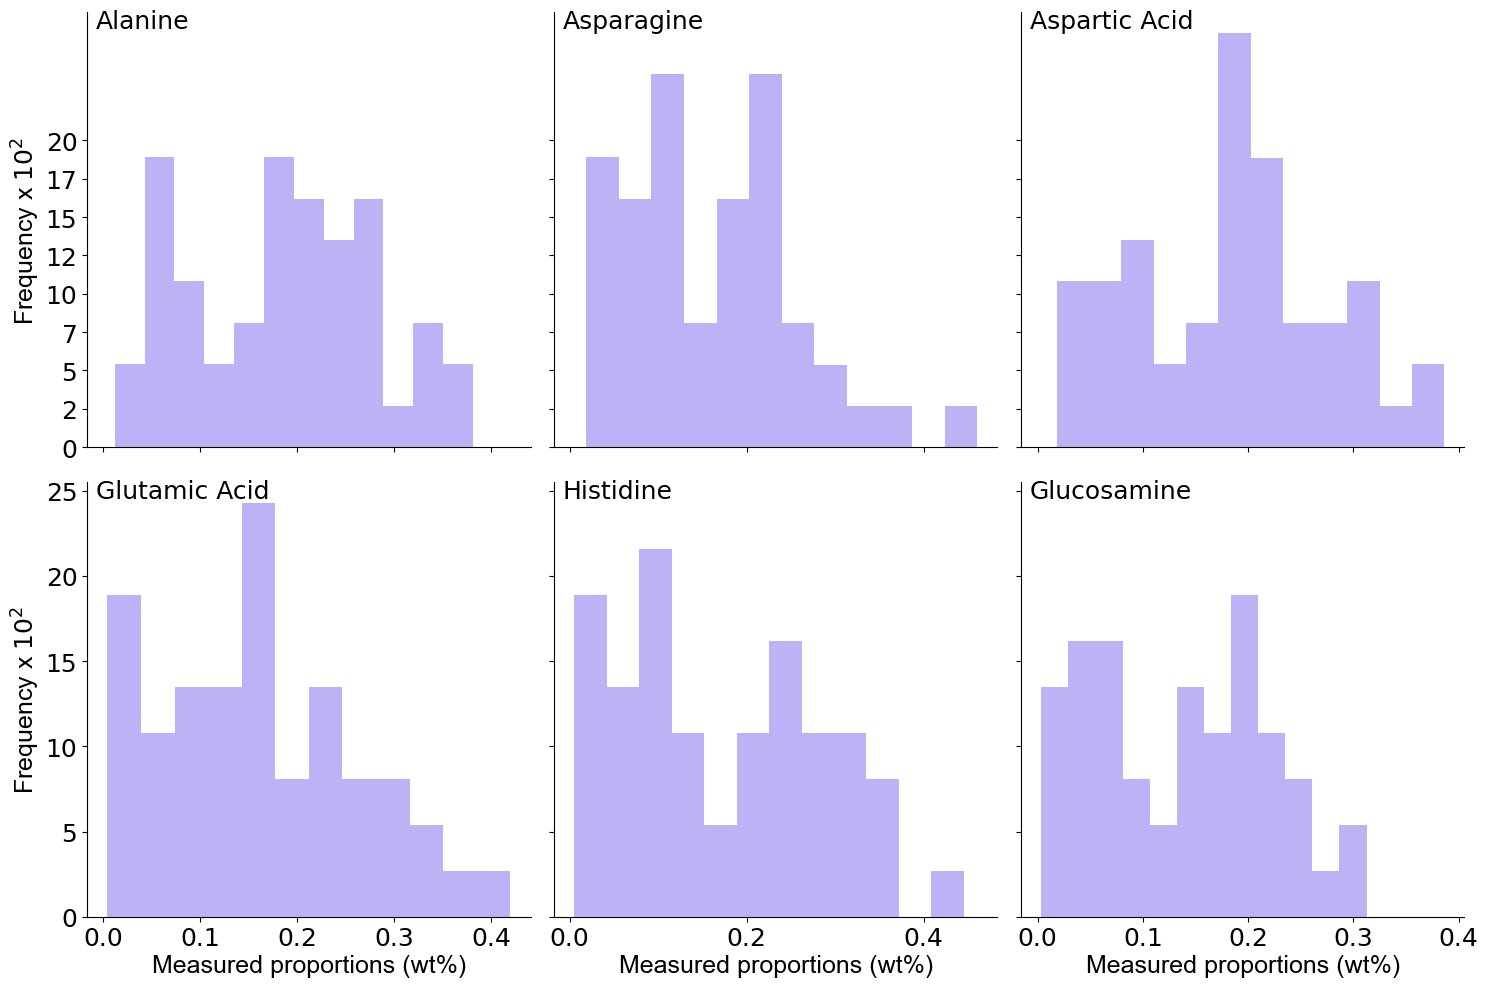

In [5]:
plot_histogram(pd.DataFrame(y_m, columns=y_names), 2, 3)

# The effect of wavelet dimensionality reduction on Raman spectra of AA data



/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/Users/mahsazarei/Grantlab Brugada Dropbox/TerraMera/Gitlab/Mahsa/AA_APLID/Amino_Acid_manuscript/helper_functions/utils.py:323: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


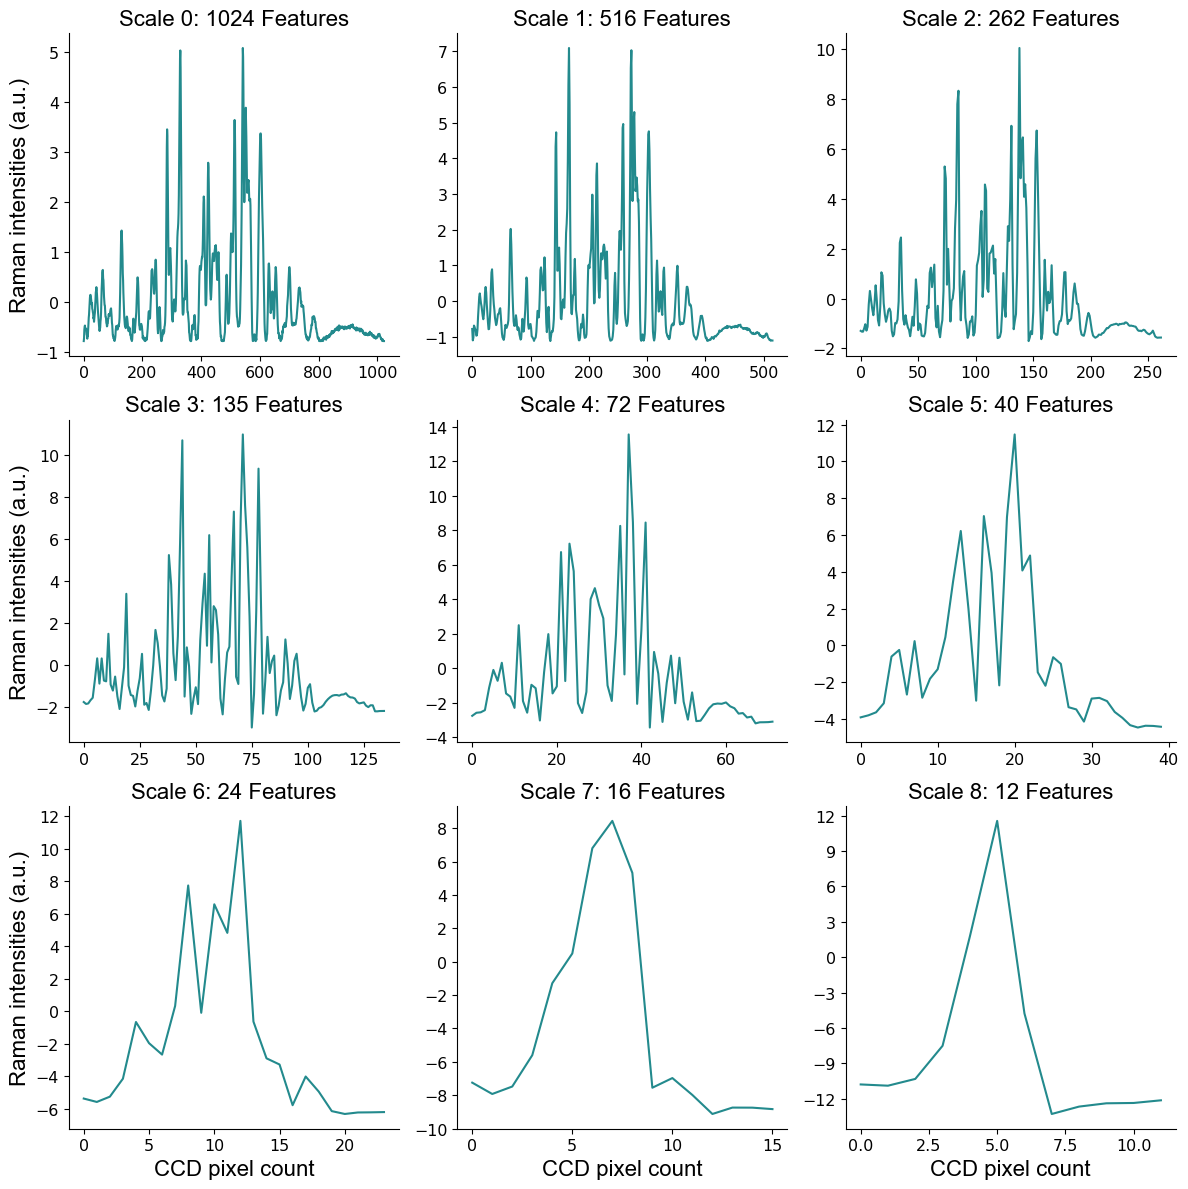

In [6]:
# 1. Background removal
scale = 7           # scale of the DWT multilevel decomposition 
wavelet = 'sym5'    # mother wavelet
iterations = 50    # Bakcground removal iterations
specs_bg_removed = np.zeros(specs_aa.shape)
bg_approx = np.zeros(specs_aa.shape)
for spectrum in range(specs_aa.shape[0]):
    specs_bg_removed[spectrum, :], bg_approx[spectrum, :] = dwt_iterative_bg_rm(specs_aa[spectrum, :], wavelet, scale, iterations)

# 2. Normalization
specss = np.vstack([norm_mean(s) for s in specs_bg_removed])

# 3. Dimensioanlity reduction
scale_values = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # List of different wavelet scale values

plot_wavelet_coeffs(specss, w_cm, scale_values)

# Savitzky-Golay smoothing effect

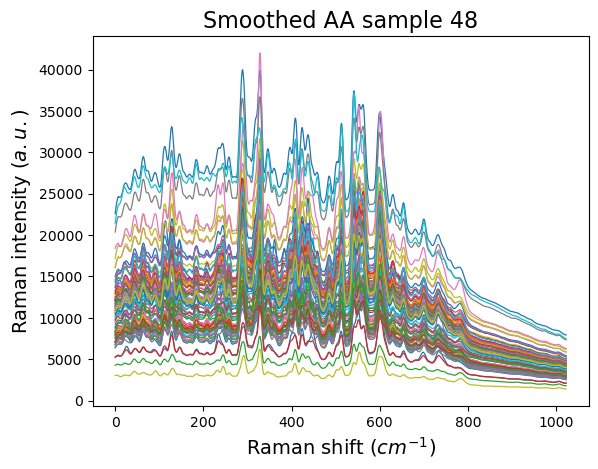

In [7]:

specss_aa_smoothed = Smoothing_Savitzky_Golay(specs_aa, window_length=15, poly_order=2)
plot_specs(specss_aa_smoothed[names_aa=='a48'], id_list=None, title="Smoothed AA sample 48", data='Raman')


# Correlation of amino acid proportions and associated Raman spectra before preprocessing


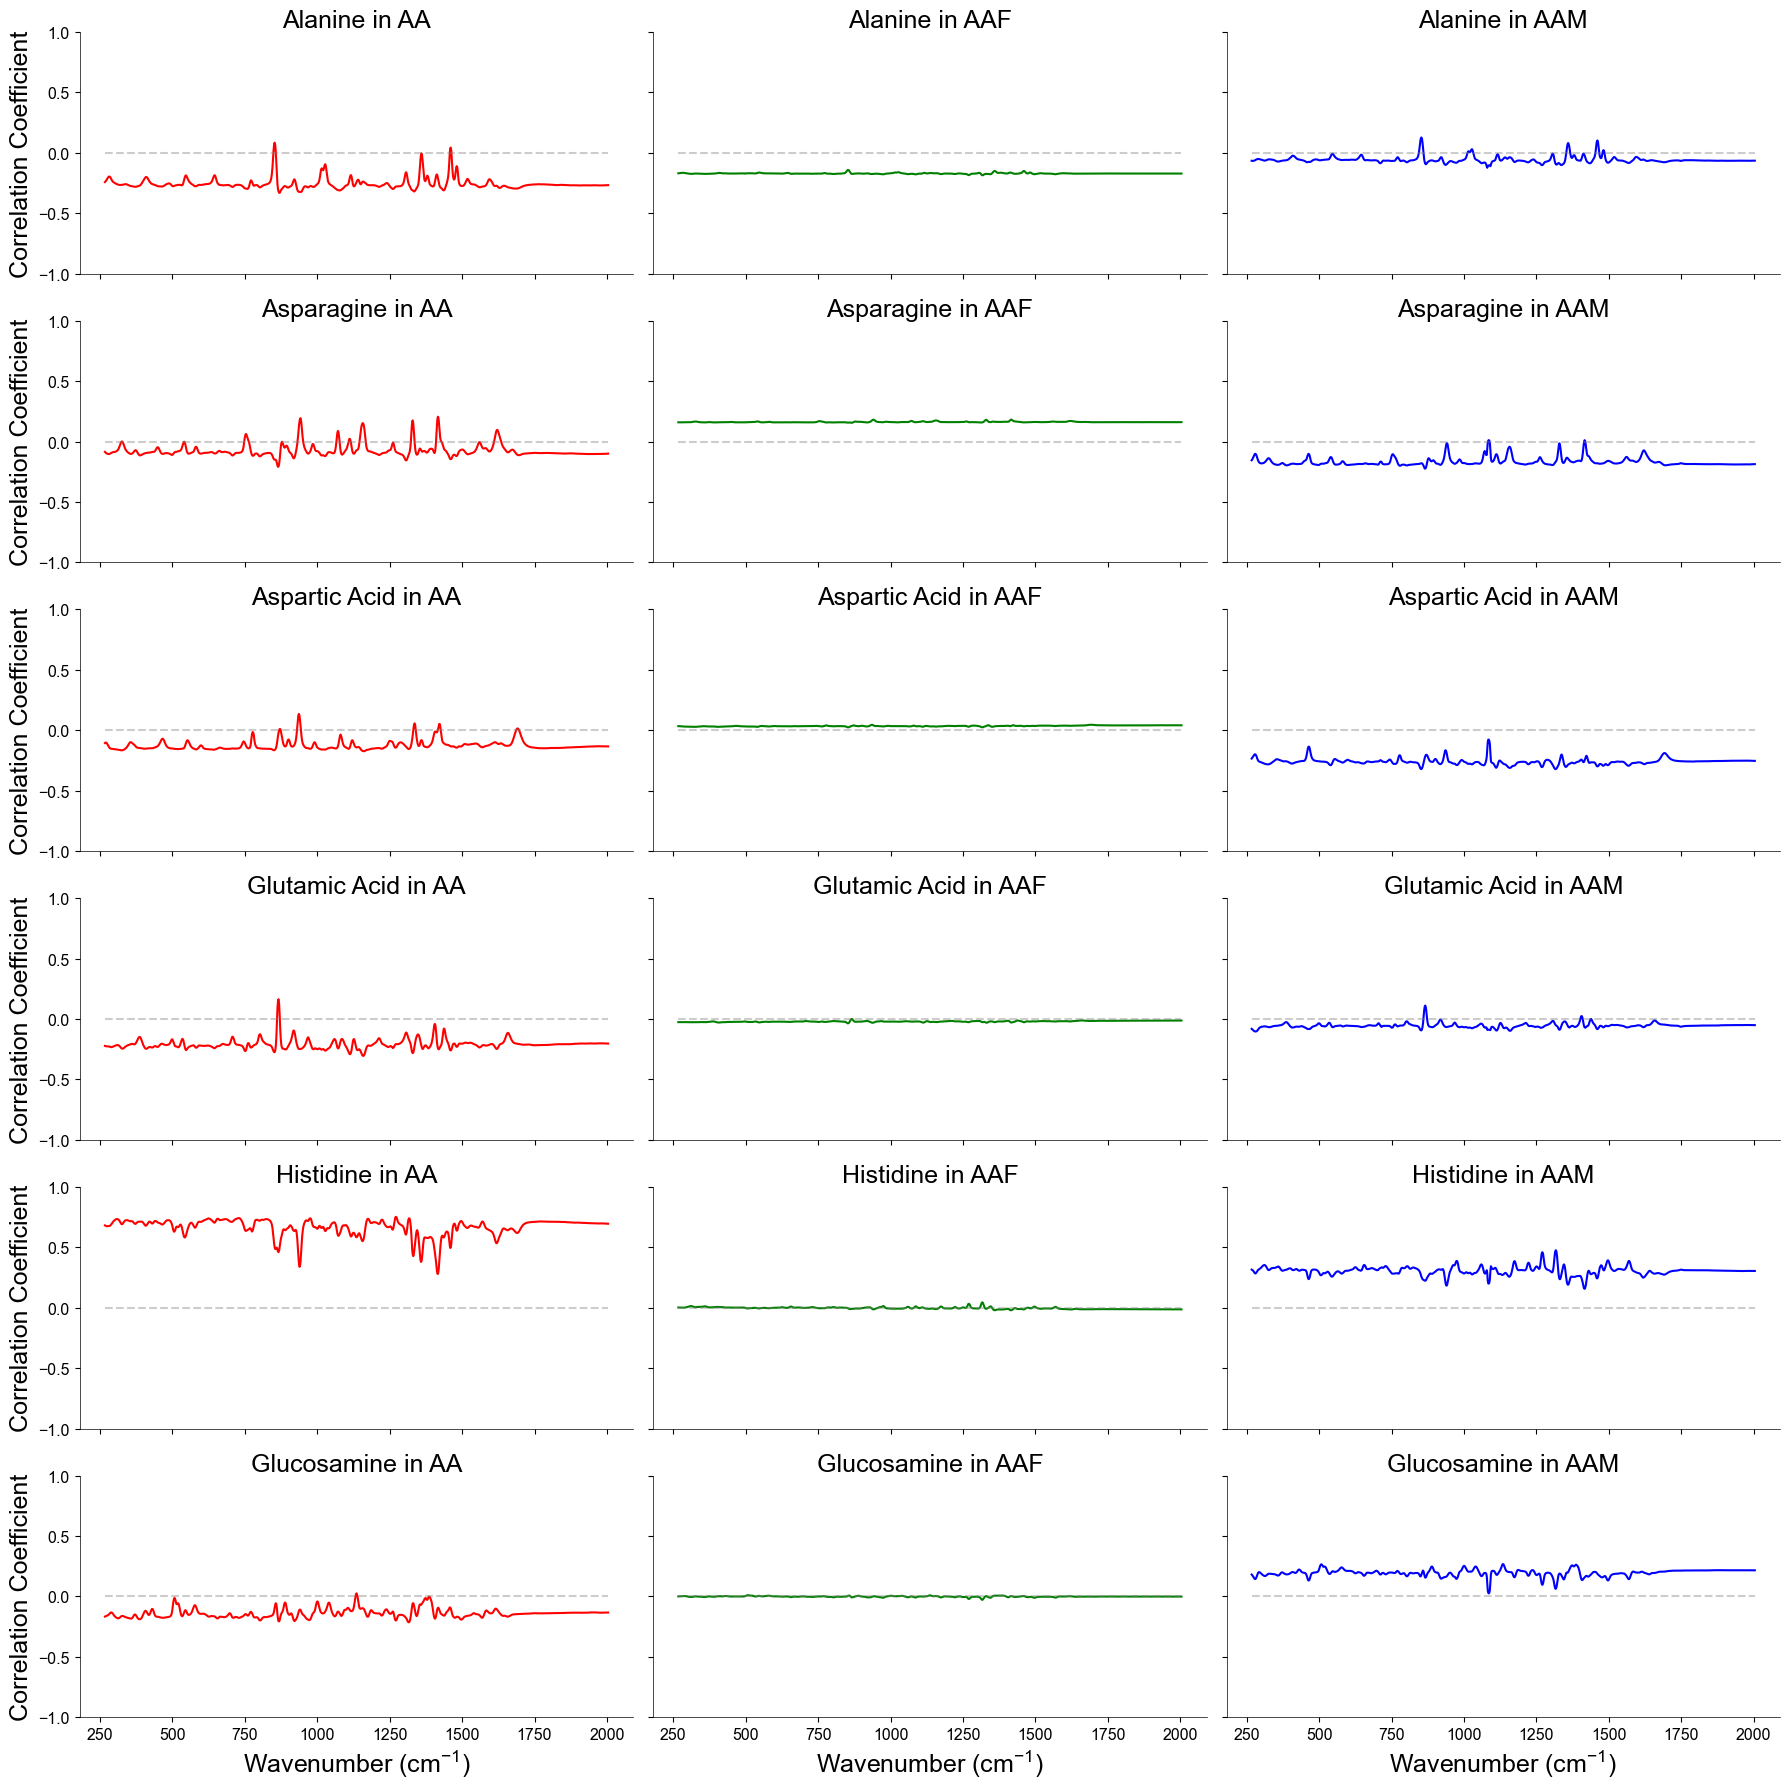

In [8]:
plot_spectrum_correlations_subplots(specs_aa, y_aa, w_cm, y_names, specs_f, y_f, specs_m, y_m)

# Correlation of amino acid proportions and associated Raman spectra after preprocessing
- 1. Background removal (except for AAM)
- 2. Normalization
- 3. Averaging

In [9]:
# 1. background removal for AA
scale_aa = 7        # scale of the DWT multilevel decomposition 
wavelet = 'sym5'    # mother wavelet
iterations = 50     # Bakcground removal iterations
specs_aa_bg_removed = np.zeros(specs_aa.shape)
for spectrum in range(specs_aa.shape[0]):
    specs_aa_bg_removed[spectrum, :], bg_approx = dwt_iterative_bg_rm(specs_aa[spectrum, :], wavelet, scale_aa, iterations)
# 1. background removal for AAF    
scale_f = 5         # scale of the DWT multilevel decomposition 
wavelet = 'sym5'    # mother wavelet
iterations = 50     # Bakcground removal iterations
specs_f_bg_removed = np.zeros(specs_f.shape)
for spectrum in range(specs_f.shape[0]):
    specs_f_bg_removed[spectrum, :], bg_approx = dwt_iterative_bg_rm(specs_f[spectrum, :], wavelet, scale_f, iterations)
   

In [10]:
# 2.Normalization
specss_aa = np.vstack([norm_mean(s) for s in specs_aa_bg_removed])
specss_f = np.vstack([norm_mean(s) for s in specs_f_bg_removed])
specss_m = np.vstack([norm_mean(s) for s in specs_m])

In [11]:
#3. Averaging
specs_aa_ave = np.vstack([np.mean(specss_aa[names_aa==name, :], axis=0) for name in np.unique(names_aa)])
y_aa_ave = np.vstack([np.mean(y_aa[names_aa==name, :], axis=0) for name in np.unique(names_aa)])

specs_f_ave = np.vstack([np.mean(specss_f[names_f==name, :], axis=0) for name in np.unique(names_f)])
y_f_ave = np.vstack([np.mean(y_f[names_f==name, :], axis=0) for name in np.unique(names_f)])

specs_m_ave = np.vstack([np.mean(specss_m[names_m==name, :], axis=0) for name in np.unique(names_m)])
y_m_ave = np.vstack([np.mean(y_m[names_m==name, :], axis=0) for name in np.unique(names_m)])


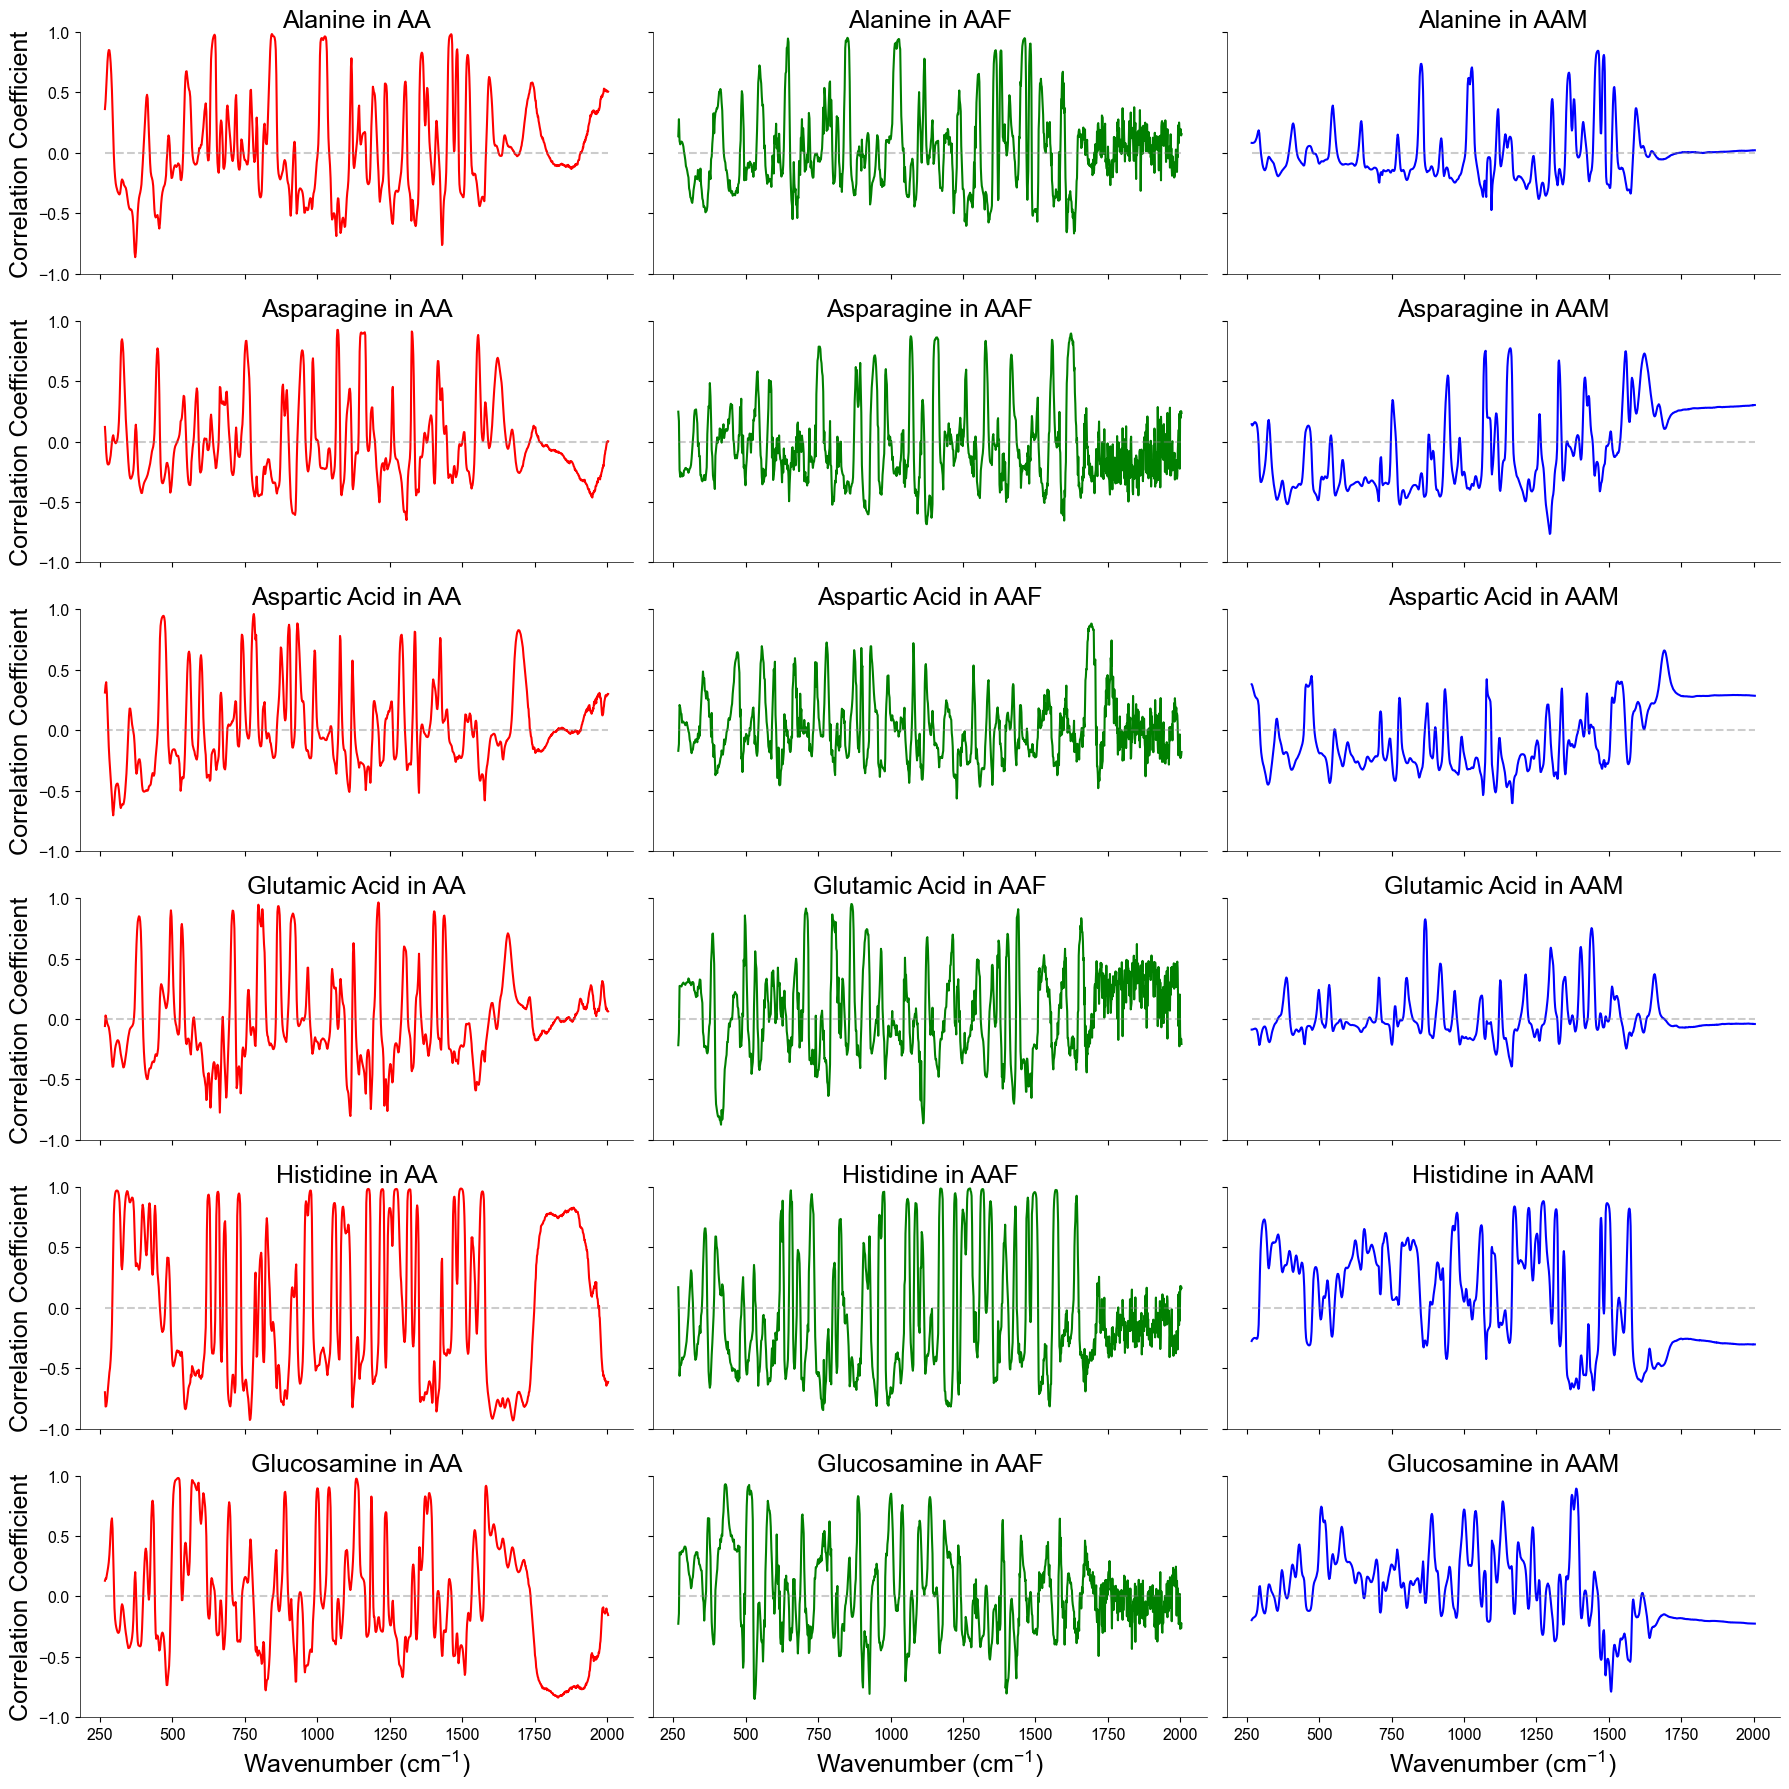

In [12]:
plot_spectrum_correlations_subplots(specs_aa_ave, y_aa_ave, w_cm, y_names, specs_f_ave, y_f_ave, specs_m_ave, y_m_ave)





# Noise addition effect

In [17]:
# SNR before nosise addition
pivot1 = 805
pivot2 = 840
SNR_raw = []
for noisy_spec in specss_aa:
    SNR_raw.append(np.divide(np.max(noisy_spec), np.std(noisy_spec[pivot1:pivot2])))
SNR_raw_mean = np.mean(np.array(SNR_raw))
SNR_raw_std = np.std(np.array(SNR_raw))
SNR_raw_mean

232.2129911611851

In [18]:
# Synthetic noisy AA data
replicas = 1
noise_amp = 40
aug_specs, aug_y, aug_names = generate_noisy_spec(specs_aa, y_aa, names_aa, replicas, 
                                                  noise_generator=np.random.randn,noise_amp=noise_amp,
                                                  pivot1=pivot1, pivot2=pivot2)

print(aug_specs.shape, aug_y.shape, aug_names.shape, y_aa.shape, specs_aa.shape, names_aa.shape)

(4318, 1024) (4318, 6) (4318,) (4318, 6) (4318, 1024) (4318,)


In [19]:
# SNR after nosise addition
aug_specs_norm = np.vstack([norm_mean(s) for s in aug_specs])
SNR_noisy = []
for noisy_spec in aug_specs_norm:
    SNR_noisy.append(np.divide(np.max(noisy_spec), np.std(noisy_spec[pivot1:pivot2])))
SNR_noisy_mean = np.mean(np.array(SNR_noisy))
SNR_noisy_mean

4.40853343670487

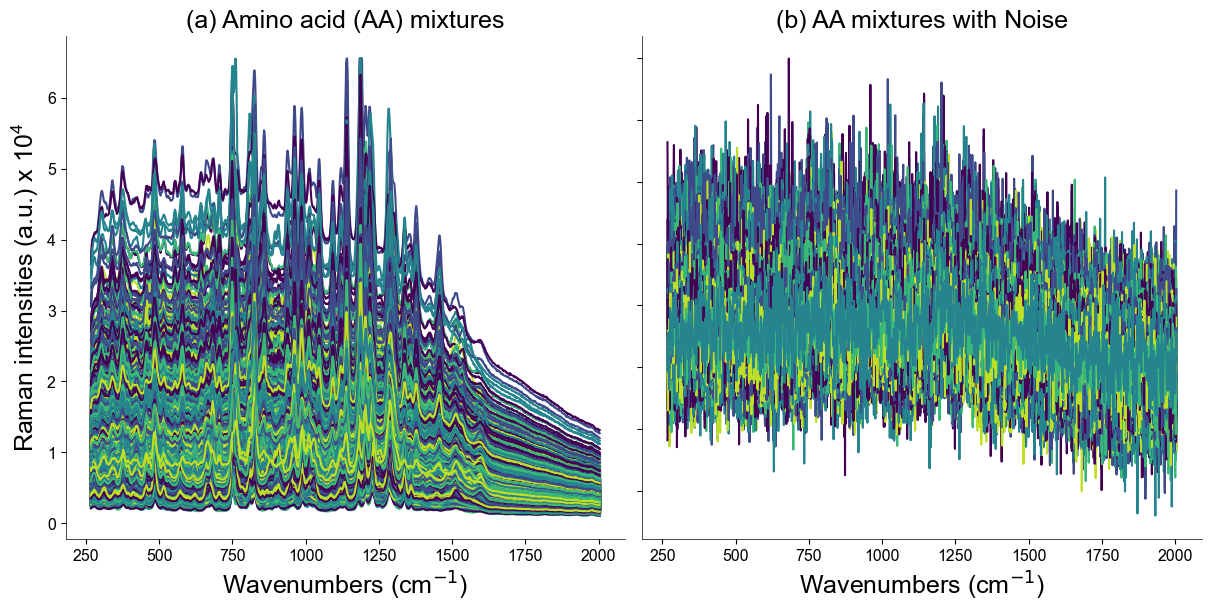

In [20]:
plot_augmented_specs(specs_aa, aug_specs, w_cm)


# Spectral composition color-coding - (after averaging)


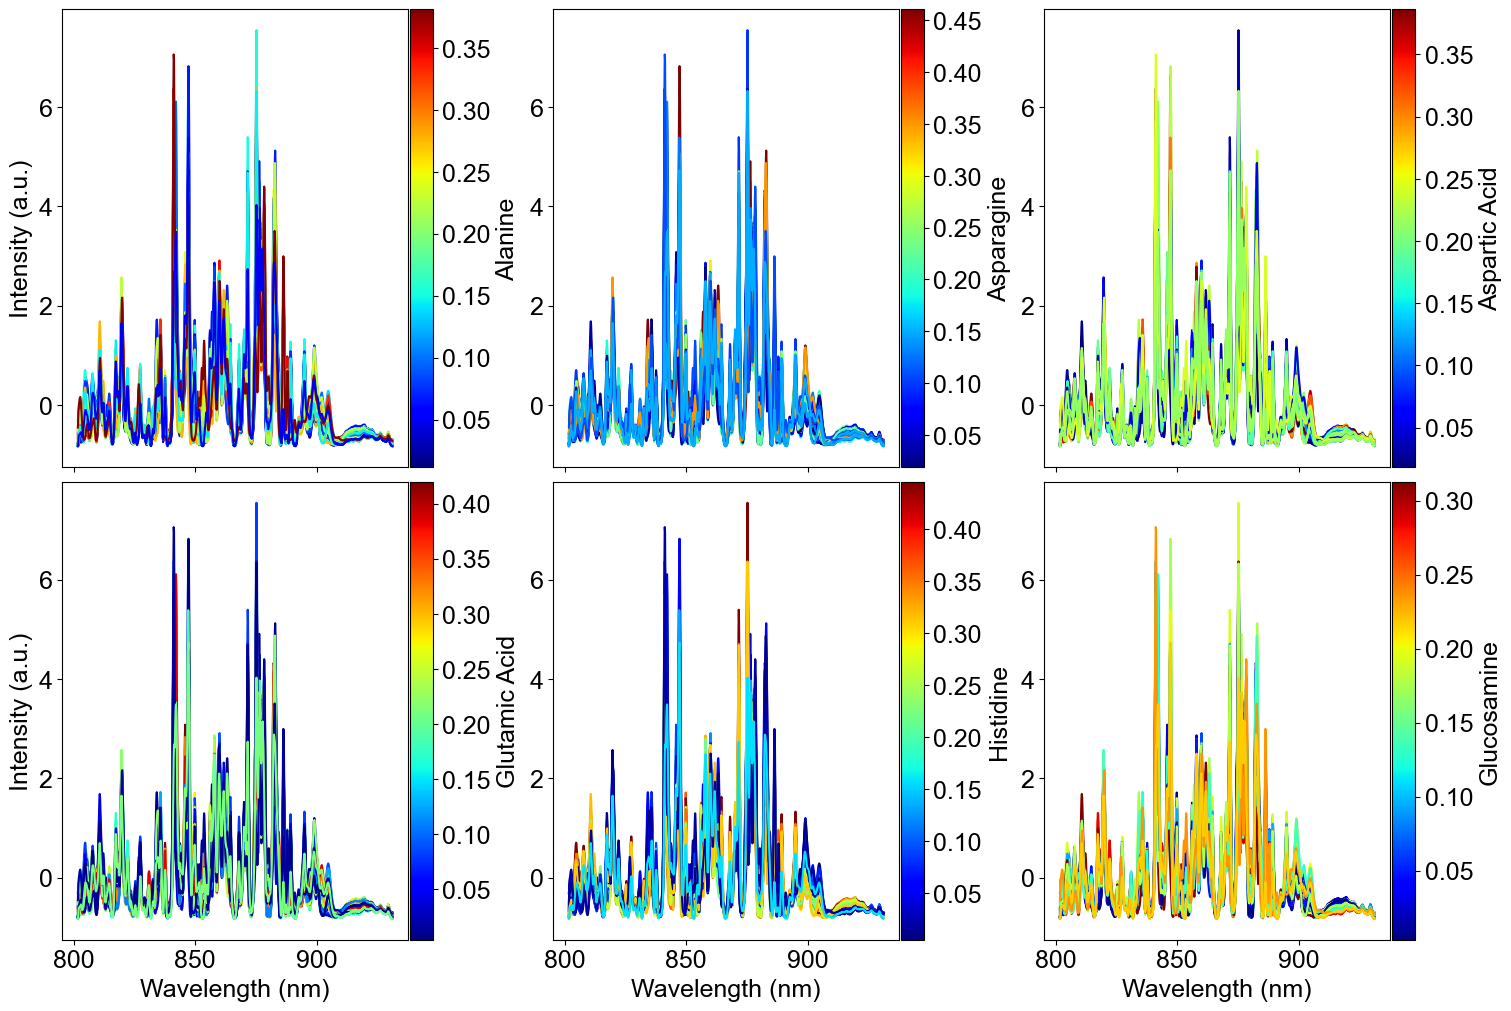

In [113]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)

for idx, ax in enumerate(axs.flat):
    spectral_ratio_color_coding(ax, w_nm, specs_aa_ave, y_aa_ave[:, idx], y_names[idx], sample_ids=None, is_first_col=(idx % 3 == 0))

for ax in axs[0]:
    ax.set_xticklabels([]) 
    ax.set_xlabel('')
plt.show()
